# 4 Crop, align eyes, scale and normalize faces in videos

**Objective:** Use openCV to read videos frame by frame. Use matplotlib or openCV to save the frames as images. Use openCV to compare frames from genuine and Deepfake videos. You can compute a simple difference between original and Deepfake frames and save the difference as an image. You can also compare the histograms of original and Deepfake frames.

Workflow: 

1. Implement crop_and_align(), which would have the following parameters: desired image size, desired eye locations (as percentages of the total face size), image from which we extract the face, and location of detected eyes.

2. Start by finding the angle between the two eyes in the image. We will use this angle to rotate the image, so the eyes of all faces will become parallel to the bottom of the image. We can compute this in the function eyes_angle().

3. Using the current distance between the eyes, the distance between the desired eyes (dictates the size of a face inside the resulting image), and the desired size of the final image, compute the scaling factor, which is the value by which we need to scale the detected faces for it to become of the desired size. We can compute this in the function scaling_factor().

4. Using the function getRotationMatrix2D() from OpenCV, compute the rotation matrix.

5. Move the center of the eyes in the desired position, and using the warpAffine() function of OpenCV, perform an affine warp of the image, resulting in the aligned and scaled face.

6. Save the output aligned faces to a disk as images (PNG is preferable because it is a lossless format).


* `./VidTIMIT/VidTIMIT` - folder with original videos
* `./DeepfakeTIMIT`- folder with Deepfake videos


# Previous code required to continue exercise

#This code is provided to you, so you can focus on the goals of this project.

### Step 1: Set the path to example videos and to datasets

In [1]:
import numpy as np
import glob
import os
import cv2
# some settings to make it smoothly runnable in Jupyter
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# the paths to the folders where all videos are
real_folder = './VidTIMIT/VidTIMIT/'
fake_folder = './DeepfakeTIMIT/higher_quality/'  # we focus on high quality videos of DeepfakeTIMIT dataset

In [3]:
# video of interest

video_id = 66 # thin vs round face
#video_id = 88 # caucasian vs asian
#video_id = 1 # standard example

In [4]:
# iterate through real and fake videos
# creates lists of real and fake videos
real_videos_list = []
fake_videos_list = []

for f in glob.glob(os.path.join(real_folder, "*/*.avi")):
    real_videos_list.append(f)
for f in glob.glob(os.path.join(fake_folder, "*/*.avi")):
    fake_videos_list.append(f)

In [5]:
# let's take one real video and one fake
real_video = real_videos_list[video_id]
fake_video = fake_videos_list[video_id]

In [6]:
real_frame_name = os.path.splitext(real_video)[0] + '_1.jpg'
fake_frame_name = os.path.splitext(fake_video)[0] + '_1.jpg'

In [7]:
real_frame_name

'./VidTIMIT/VidTIMIT\\fdac1\\sx214_1.jpg'

In [8]:
fake_frame_name

'./DeepfakeTIMIT/higher_quality\\fedw0\\sx274-video-faks0_1.jpg'

In [9]:
real_video

'./VidTIMIT/VidTIMIT\\fdac1\\sx214.avi'

In [10]:
fake_video

'./DeepfakeTIMIT/higher_quality\\fedw0\\sx274-video-faks0.avi'

### Step 3 Crop, align, scaling, normalization

In [11]:
def eyes_angle(left_eye, right_eye):
    # find the distances between X and Y coordinates of both eyes
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    # compute the angle using trigonometry
    angle = np.degrees(np.arctan2(dY, dX))
    return angle

In [12]:
def scaling_factor(left_eye, right_eye, desired_left_eye, desired_right_eye):
    # find the distances between X and Y coordinates of both eyes
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    # find the actual distance between eyes (the hypotenuse)
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    # find the distance between X and Y coordinates in the desired face (which we will have after scaling)
    desired_dY = desired_right_eye[1] - desired_left_eye[1]
    desired_dX = desired_right_eye[0] - desired_left_eye[0]
    # find the  distance between desired eye coordinates (the hypotenuse)
    desired_dist = np.sqrt((desired_dX ** 2) + (desired_dY ** 2))
    
    # compute the ratio between distances, which is the scale factor
    scaling_factor = desired_dist / dist
    return scaling_factor   

In [13]:
def crop_and_align(image, left_eye, right_eye, desired_image_width, 
                   desired_left_eye_percentage):
    # find angle of the line between the eyes
    angle = eyes_angle(left_eye, right_eye)

    # assuming desired_left_eye_percentage tells where the eyes should be relative to the image size
    # compute its actual place in the resulted image
    desired_left_eye = (desired_left_eye_percentage[0]*desired_image_width, 
                        desired_left_eye_percentage[1]*desired_image_width)
    # similar compute the mirror coordinates for desired_right_eye
    desired_right_eye = ((1.0-desired_left_eye_percentage[0])*desired_image_width, 
                        desired_left_eye_percentage[1]*desired_image_width)

    # find scaling factor based on where we want our eyes to be in the resulted image
    scale = scaling_factor(left_eye, right_eye, desired_left_eye, desired_right_eye)
    
    # find the center point between two eyes, around which we will rotate the image
    eyes_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    # compute the rotation matrix using OpenCV, rotate and scale around the eyes_center
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # move the current center of the eyes to the desired coordinates, which are
    # mid point horizontally and the desired level vertically
    tX = desired_image_width * 0.5
    tY = desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # by specifying height and width of the final image
    # as our desired_image_width, we insruct warpAffine to cut off the extra pixels
    w = desired_image_width
    h = desired_image_width

    # using OpenCV warpAffine() apply the M transformation, which will also crop the image
    aligned = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    return aligned

In [14]:
from mtcnn import MTCNN
detector = MTCNN()

In [15]:
# detect one face and its eyes coordinates in the given image
def detect_face(image, desired_size=224, desired_left_eye_percentage=(0.35, 0.35)):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detection_result = detector.detect_faces(image_rgb)
    left_eye = detection_result[0]['keypoints']['left_eye']
    right_eye = detection_result[0]['keypoints']['right_eye']
    face = crop_and_align(image, left_eye, right_eye, desired_size, desired_left_eye_percentage)
    if face is not None:
        return face
    return None

In [16]:
# loop through frames in the video and detect faces
def detect_and_save_faces(video_path, limit_faces=-1, save_faces=True):
    detector = MTCNN()
    faces = list()
    # add '_face' at the end to differentiate face images
    face_name = os.path.splitext(video_path)[0] + '_face'
    
    cap = cv2.VideoCapture(video_path)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_no in range(num_frames):
        # if the given limit is not -1, loop only until the limit
        if limit_faces != -1 and frame_no >= limit_faces:
            break
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        ret, frame = cap.read()
        # detect faces
        face = detect_face(frame, desired_size=256, desired_left_eye_percentage=(0.35, 0.35))
        if face is not None:
            faces.append(face)
            if save_faces:
                cv2.imwrite(face_name + '_' + str(frame_no) + '.png', face)
    return faces

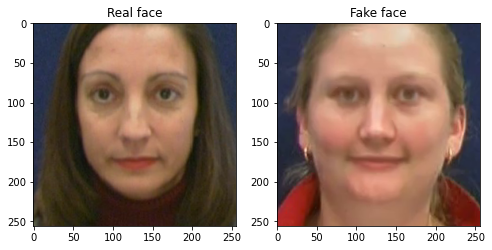

In [17]:
# running provided code on one real and one fake video
real_faces = detect_and_save_faces(real_video, limit_faces=5)
fake_faces = detect_and_save_faces(fake_video, limit_faces=5)

# convert the list of faces to the numpy array
# define a function that will read and display given images
def display_images_side_by_side(im1, im2):
    # note that images in OpenCV are in BGR format, 
    # and to plot with matplotlib, we convert them to RGB
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

    # show the images side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im1)
    plt.title('Real face')
    plt.subplot(1, 2, 2)
    plt.title('Fake face')
    plt.imshow(im2)
    plt.show()

# plot real and fake faces side by side
display_images_side_by_side(real_faces[0], fake_faces[0])

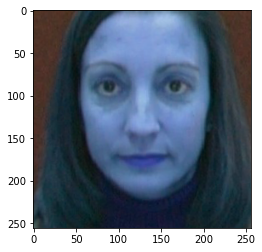

In [18]:
plt.imshow(real_faces[0])           

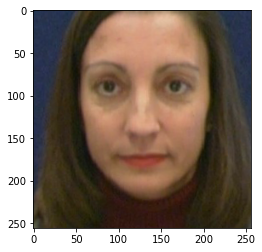

In [19]:
plt.imshow(cv2.cvtColor(real_faces[0], cv2.COLOR_BGR2RGB))           

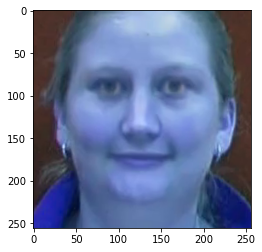

In [20]:
plt.imshow(fake_faces[0]) 

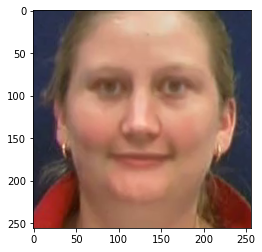

In [21]:
plt.imshow(cv2.cvtColor(fake_faces[0], cv2.COLOR_BGR2RGB))           

In [22]:
# note that images in OpenCV are in BGR format, 
# and to plot with matplotlib, we convert them to RGB
#real_image = cv2.imread(real_faces[0])
#fake_image = cv2.imread(fake_faces[0])
#real_image = cv2.cvtColor(real_faces[0], cv2.COLOR_BGR2RGB)
#fake_image = cv2.cvtColor(fake_faces[0], cv2.COLOR_BGR2RGB)

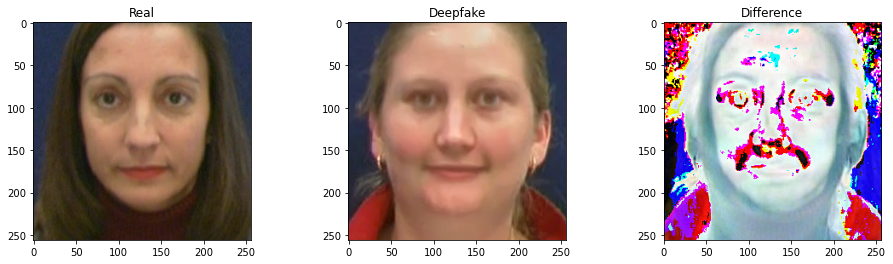

In [23]:
# note that images in OpenCV are in BGR format, 
# and to plot with matplotlib, we convert them to RGB
real_image = cv2.cvtColor(real_faces[0], cv2.COLOR_BGR2RGB)
fake_image = cv2.cvtColor(fake_faces[0], cv2.COLOR_BGR2RGB)

# find the difference between the images
image_diff = None
if real_image.shape == fake_image.shape:
    image_diff = real_image - fake_image

# show the images side by side
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(real_image)
plt.title('Real')
plt.subplot(1, 3, 2)
plt.title('Deepfake')
plt.imshow(fake_image)
if image_diff is not None:
    plt.subplot(1, 3, 3)
    plt.title('Difference')
    plt.imshow(image_diff)
plt.show()


### Step 3 Run provided code for computing features

 Run code and compute features for two faces, as an example

In [24]:
real_image = cv2.imread(real_frame_name)

In [25]:
fake_image = cv2.imread(fake_frame_name)

In [26]:
# data in BGR format 

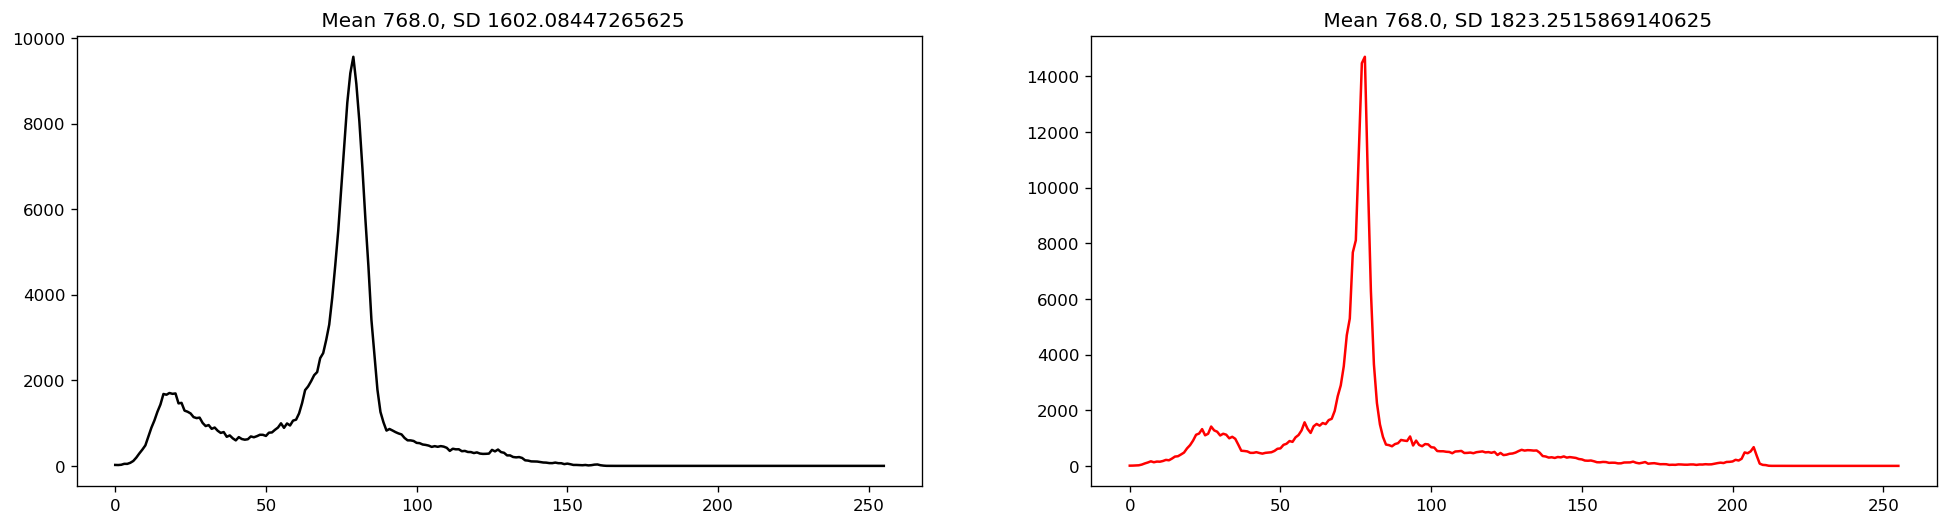

In [27]:
fig = plt.figure(figsize=(20, 10), dpi=120)
plt.subplots_adjust(top = 0.5)
fig.tight_layout()

#Real
ax = fig.add_subplot(1,2,1)
p1 = cv2.calcHist([real_image],[0],None,[256],[0,256])  
ax.plot(p1,color = 'black')
ax.set_title(f' Mean {p1.mean()}, SD {p1.std()}')

#Fake
ax2 = fig.add_subplot(1,2,2)
p2 = cv2.calcHist([fake_image],[0],None,[256],[0,256])
ax2.set_title(f' Mean {p2.mean()}, SD {p2.std()}')
ax2.plot(p2,color = 'red')

cv2.destroyAllWindows()

In [28]:
# convert between RGB and BGR color spaces (with or without alpha channel)
# images in OpenCV are in BGR format, we convert them to RGB

In [29]:
real_image = cv2.imread(real_frame_name)
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)

In [30]:
fake_image = cv2.imread(fake_frame_name)
fake_image = cv2.cvtColor(fake_image, cv2.COLOR_BGR2RGB)

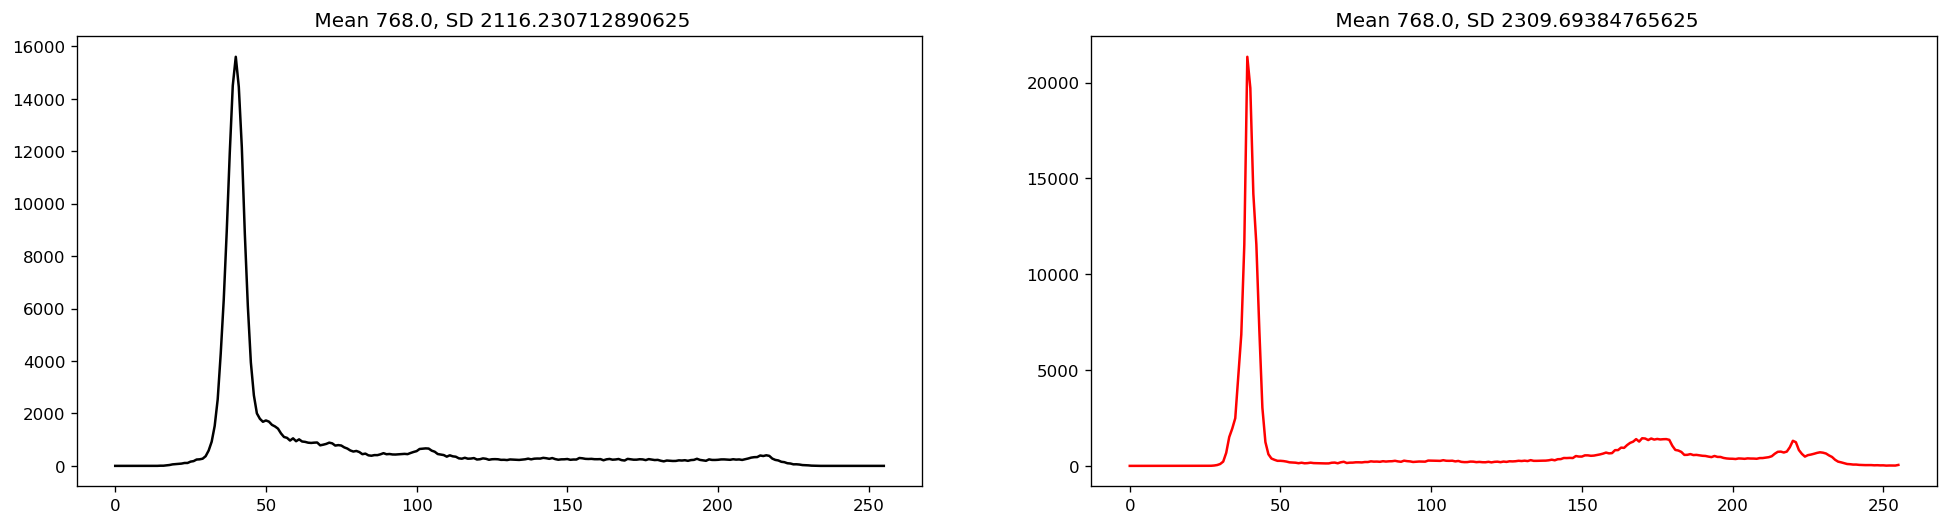

In [31]:
fig = plt.figure(figsize=(20, 10), dpi=120)
plt.subplots_adjust(top = 0.5)
fig.tight_layout()

#Real
ax = fig.add_subplot(1,2,1)
p1 = cv2.calcHist([real_image],[0],None,[256],[0,256])  
ax.plot(p1,color = 'black')
ax.set_title(f' Mean {p1.mean()}, SD {p1.std()}')

#Fake
ax2 = fig.add_subplot(1,2,2)
p2 = cv2.calcHist([fake_image],[0],None,[256],[0,256])
ax2.set_title(f' Mean {p2.mean()}, SD {p2.std()}')
ax2.plot(p2,color = 'red')

cv2.destroyAllWindows()

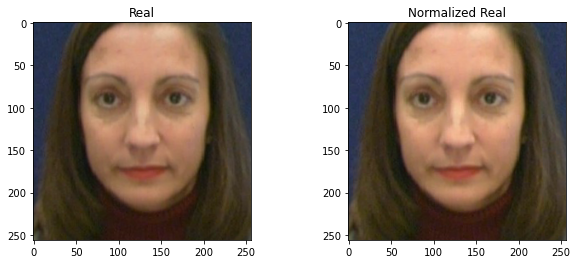

In [32]:
real_image = cv2.cvtColor(real_faces[0], cv2.COLOR_BGR2RGB)

norm_img_r = np.zeros((300, 300))
norm_img_r = cv2.normalize(real_image, norm_img_r, 0, 255, cv2.NORM_MINMAX)

# show the images side by side
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(real_image)
plt.title('Real')
plt.subplot(1, 3, 2)
plt.title('Normalized Real')
plt.imshow(norm_img_r)

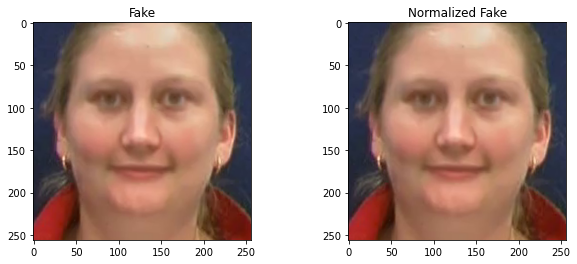

In [33]:
fake_image = cv2.cvtColor(fake_faces[0], cv2.COLOR_BGR2RGB)

norm_img_f = np.zeros((300, 300))
norm_img_f = cv2.normalize(fake_image, norm_img_f, 0, 255, cv2.NORM_MINMAX)

# show the images side by side
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(fake_image)
plt.title('Fake')
plt.subplot(1, 3, 2)
plt.title('Normalized Fake')
plt.imshow(norm_img_f)

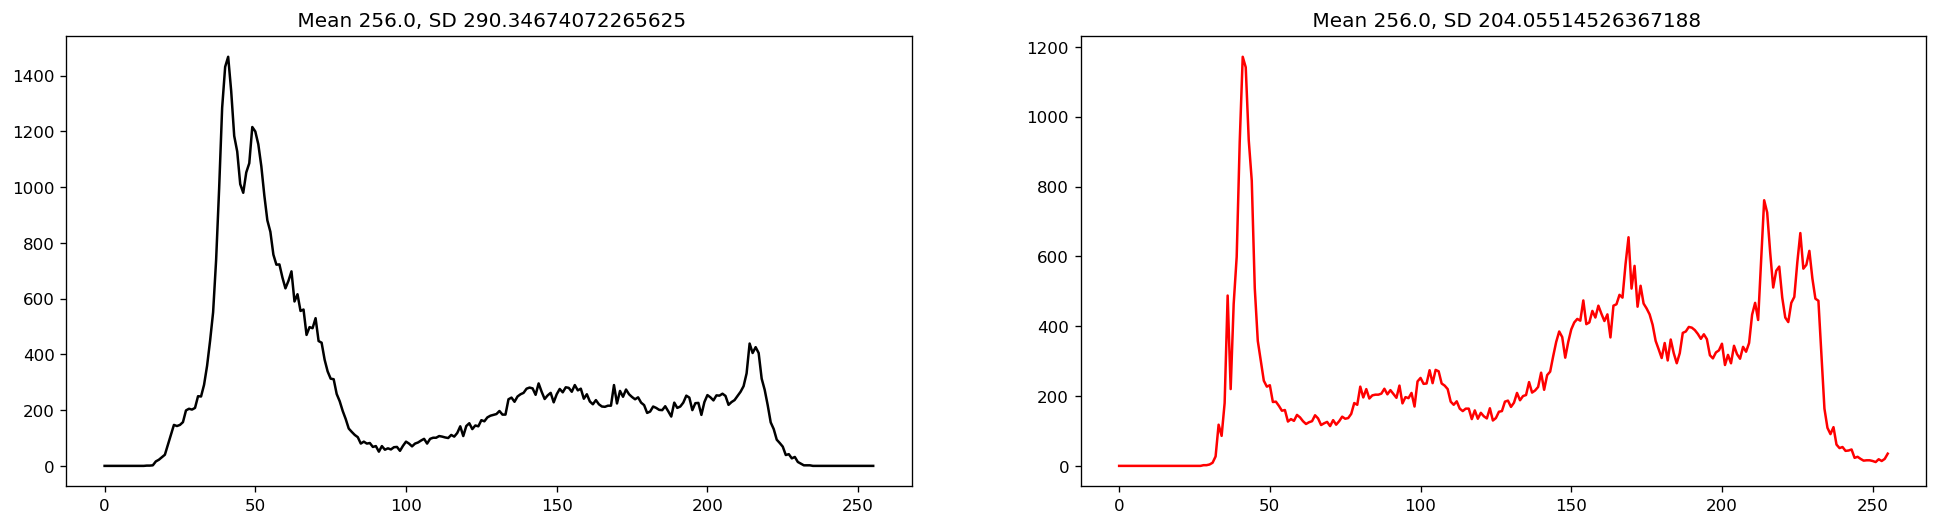

In [34]:
fig = plt.figure(figsize=(20, 10), dpi=120)
plt.subplots_adjust(top = 0.5)
fig.tight_layout()

#Real on the left
ax = fig.add_subplot(1,2,1)
p1 = cv2.calcHist([real_image],[0],None,[256],[0,256])  
ax.plot(p1,color = 'black')
ax.set_title(f' Mean {p1.mean()}, SD {p1.std()}')

#Fake on the right
ax2 = fig.add_subplot(1,2,2)
p2 = cv2.calcHist([fake_image],[0],None,[256],[0,256])
ax2.set_title(f' Mean {p2.mean()}, SD {p2.std()}')
ax2.plot(p2,color = 'red')

cv2.destroyAllWindows()

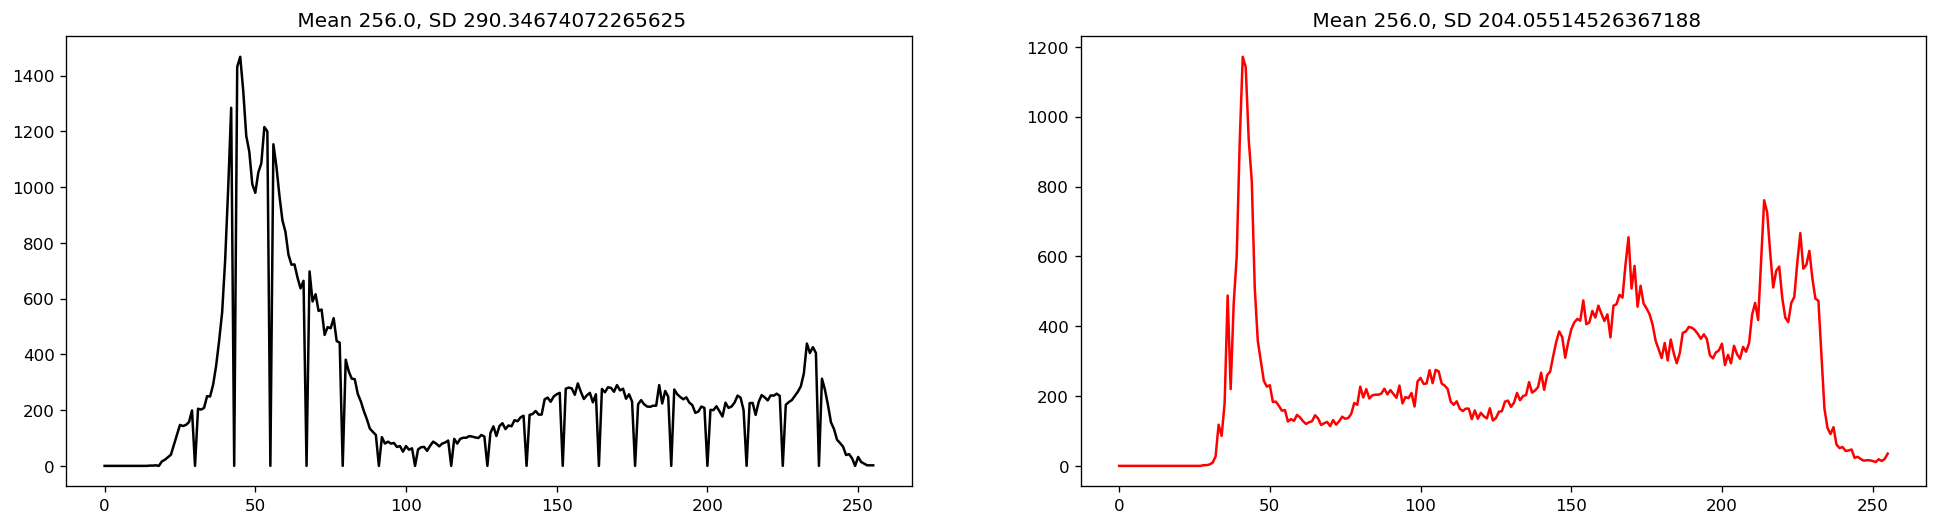

In [35]:
fig = plt.figure(figsize=(20, 10), dpi=120)
plt.subplots_adjust(top = 0.5)
fig.tight_layout()

# normalized Real on the left
ax = fig.add_subplot(1,2,1)
p1 = cv2.calcHist([norm_img_r],[0],None,[256],[0,256])  
ax.plot(p1,color = 'black')
ax.set_title(f' Mean {p1.mean()}, SD {p1.std()}')

# normalized Fake on the right
ax2 = fig.add_subplot(1,2,2)
p2 = cv2.calcHist([norm_img_f],[0],None,[256],[0,256])
ax2.set_title(f' Mean {p2.mean()}, SD {p2.std()}')
ax2.plot(p2,color = 'red')

cv2.destroyAllWindows()

### The actual features

try them all

In [36]:
import skimage.metrics
num_hist_bins = 32

# Note that the number of bins we use for the histogram is a parameter of the system
# more bins - more features
def compute_hist(image, num_bins=32):
    hist, bins = np.histogram(image.ravel(), num_bins, [0,255], density=True)
    return hist


def compute_blurred_image(image, kernel_size=3, sigma=0.5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def mse(x, y):
    return skimage.metrics.normalized_root_mse(x, y)

def psnr(x, y):
    return skimage.metrics.peak_signal_noise_ratio(x, y, data_range=255)

def ssim(x, y):
    return skimage.metrics.structural_similarity(x, y, multichannel=True, 
                                                 gaussian_weights=True, sigma=1.5, 
                                                 use_sample_covariance=False, data_range=255)

def compute_features(image):
    image_blurred = compute_blurred_image(image)
    im_ssim = ssim(image, image_blurred)
    im_mse = mse(image, image_blurred)
    im_psnr = psnr(image, image_blurred)
    im_hist = compute_hist(image, num_bins=num_hist_bins)
    features = np.concatenate([[im_ssim], [im_mse], [im_psnr], im_hist])
    return features

# as an example, compute features just for one real and one fake faces
real_feature = compute_features(real_faces[0])
fake_feature = compute_features(fake_faces[0])
print("Real feature vector:\n {} \nof length {}".format(real_feature, len(real_feature)))
print("Deepfake feature vector:\n {} \nof length {}".format(fake_feature, len(fake_feature)))

# notice the last values in both case are zeros, 
# that's because these face have not bright pixels with values near 255,
# so, the last bin of the histogram becomes empty 

Real feature vector:
 [9.97352346e-01 5.87794529e-03 5.31932736e+01 3.22329453e-04
 3.54690053e-03 7.84122243e-03 8.15014808e-03 8.96458844e-03
 1.20034212e-02 1.43656812e-02 8.74948938e-03 7.32230392e-03
 6.56849980e-03 4.11560458e-03 3.33690768e-03 3.54115605e-03
 3.67008783e-03 3.80029616e-03 4.10283905e-03 3.69753370e-03
 3.35924734e-03 3.02032271e-03 3.26350592e-03 2.06546160e-03
 1.76802492e-03 1.28612643e-03 1.16166258e-03 1.15910948e-03
 1.25676573e-03 1.55994690e-03 1.28740298e-03 1.99780433e-04
 3.82965686e-06 0.00000000e+00 0.00000000e+00] 
of length 35
Deepfake feature vector:
 [9.98417351e-01 4.80354802e-03 5.24079619e+01 1.67228350e-04
 8.51460376e-04 1.23442606e-03 1.55994690e-03 3.42179841e-03
 7.47995813e-03 7.57250817e-03 4.63388480e-03 5.03663705e-03
 7.42378983e-03 6.24680862e-03 6.32404003e-03 5.78214359e-03
 5.82809947e-03 5.97426471e-03 5.92256434e-03 6.03681577e-03
 5.06535948e-03 5.24982128e-03 5.61683007e-03 4.30325776e-03
 4.62048100e-03 3.04266238e-03 2.5199

In [37]:
compute_hist(real_image)

array([3.22329453e-04, 3.54690053e-03, 7.84122243e-03, 8.15014808e-03,
       8.96458844e-03, 1.20034212e-02, 1.43656812e-02, 8.74948938e-03,
       7.32230392e-03, 6.56849980e-03, 4.11560458e-03, 3.33690768e-03,
       3.54115605e-03, 3.67008783e-03, 3.80029616e-03, 4.10283905e-03,
       3.69753370e-03, 3.35924734e-03, 3.02032271e-03, 3.26350592e-03,
       2.06546160e-03, 1.76802492e-03, 1.28612643e-03, 1.16166258e-03,
       1.15910948e-03, 1.25676573e-03, 1.55994690e-03, 1.28740298e-03,
       1.99780433e-04, 3.82965686e-06, 0.00000000e+00, 0.00000000e+00])

In [38]:
compute_blurred_image(real_image)

array([[[ 38,  51,  82],
        [ 33,  50,  77],
        [ 36,  53,  80],
        ...,
        [ 41,  52,  80],
        [ 41,  52,  79],
        [ 38,  49,  76]],

       [[ 38,  51,  82],
        [ 35,  52,  79],
        [ 38,  55,  82],
        ...,
        [ 41,  52,  80],
        [ 41,  52,  80],
        [ 38,  49,  77]],

       [[ 37,  52,  83],
        [ 35,  52,  79],
        [ 36,  53,  80],
        ...,
        [ 41,  52,  81],
        [ 42,  52,  81],
        [ 40,  51,  79]],

       ...,

       [[ 98, 101,  80],
        [ 94,  97,  76],
        [ 88,  91,  70],
        ...,
        [ 65,  64,  55],
        [ 71,  70,  62],
        [ 73,  72,  64]],

       [[ 99, 102,  83],
        [ 95,  98,  79],
        [ 89,  92,  72],
        ...,
        [ 67,  66,  57],
        [ 72,  71,  63],
        [ 74,  73,  65]],

       [[100, 103,  84],
        [ 96,  99,  80],
        [ 90,  93,  73],
        ...,
        [ 68,  67,  59],
        [ 73,  72,  64],
        [ 75,  74,  66]]

In [39]:
im_ssim = ssim(real_image, norm_img_r)
im_ssim

0.9941212263906061

In [40]:
im_mse = mse(real_image, norm_img_r)
im_mse

0.08972139197447677

In [41]:
im_psnr = psnr(real_image, norm_img_r)
im_psnr

29.519864291351006

In [42]:
im_hist = compute_hist(real_image, num_bins=num_hist_bins)
im_hist

array([3.22329453e-04, 3.54690053e-03, 7.84122243e-03, 8.15014808e-03,
       8.96458844e-03, 1.20034212e-02, 1.43656812e-02, 8.74948938e-03,
       7.32230392e-03, 6.56849980e-03, 4.11560458e-03, 3.33690768e-03,
       3.54115605e-03, 3.67008783e-03, 3.80029616e-03, 4.10283905e-03,
       3.69753370e-03, 3.35924734e-03, 3.02032271e-03, 3.26350592e-03,
       2.06546160e-03, 1.76802492e-03, 1.28612643e-03, 1.16166258e-03,
       1.15910948e-03, 1.25676573e-03, 1.55994690e-03, 1.28740298e-03,
       1.99780433e-04, 3.82965686e-06, 0.00000000e+00, 0.00000000e+00])

In [43]:
im_ssim = ssim(fake_image, norm_img_f)
im_ssim

1.0

In [44]:
im_mse = mse(fake_image, norm_img_f)
im_mse

0.0

In [45]:
im_psnr = psnr(fake_image, norm_img_f)
im_psnr

C:\Users\VS\Anaconda3\envs\deepfake-detection\lib\site-packages\skimage\metrics\simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


inf

In [46]:
im_hist = compute_hist(fake_image, num_bins=num_hist_bins)
im_hist

array([1.67228350e-04, 8.51460376e-04, 1.23442606e-03, 1.55994690e-03,
       3.42179841e-03, 7.47995813e-03, 7.57250817e-03, 4.63388480e-03,
       5.03663705e-03, 7.42378983e-03, 6.24680862e-03, 6.32404003e-03,
       5.78214359e-03, 5.82809947e-03, 5.97426471e-03, 5.92256434e-03,
       6.03681577e-03, 5.06535948e-03, 5.24982128e-03, 5.61683007e-03,
       4.30325776e-03, 4.62048100e-03, 3.04266238e-03, 2.51991422e-03,
       2.38587623e-03, 1.89695670e-03, 2.68841912e-03, 2.58118873e-03,
       2.87671058e-03, 8.80182802e-04, 1.73611111e-04, 9.25500408e-05])

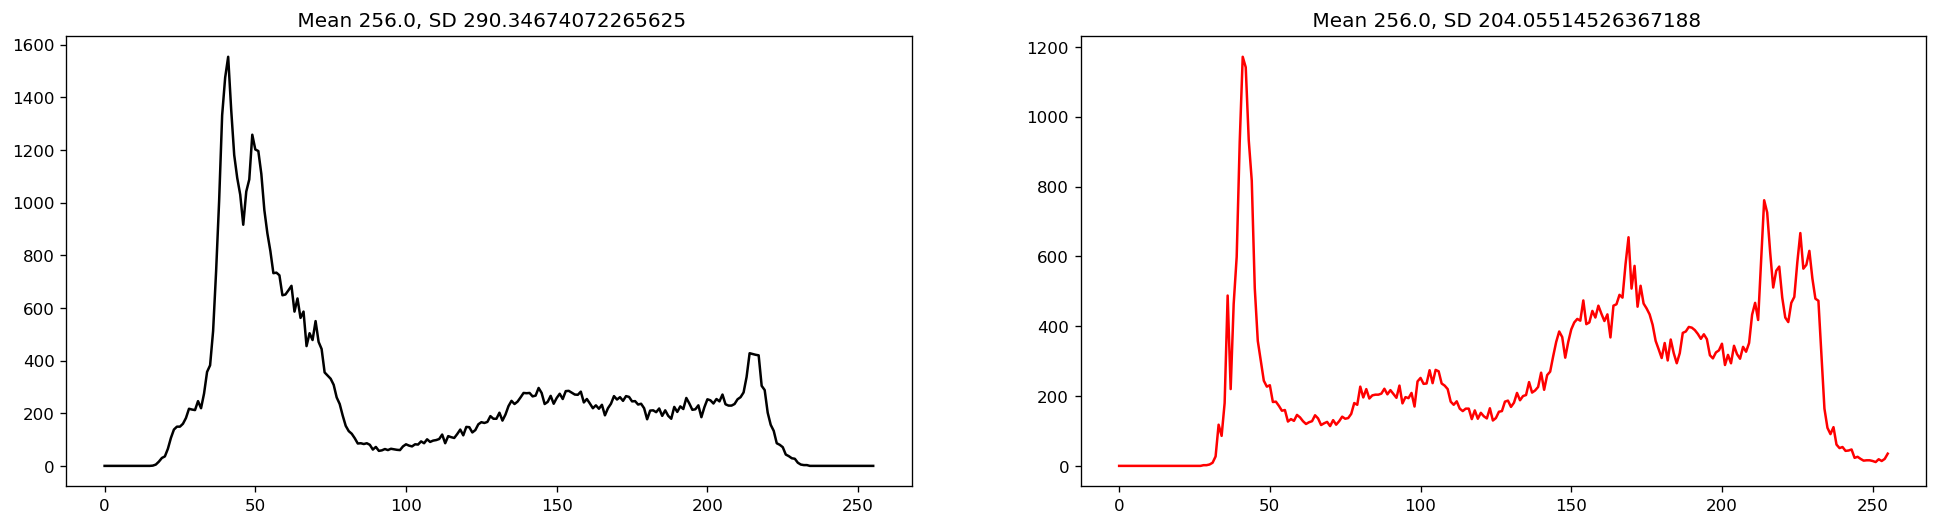

In [47]:
fig = plt.figure(figsize=(20, 10), dpi=120)
plt.subplots_adjust(top = 0.5)
fig.tight_layout()

# blurred Real on the left
ax = fig.add_subplot(1,2,1)
histr = cv2.calcHist([compute_blurred_image(real_image)],[0],None,[256],[0,256])  
ax.plot(histr,color = 'black')
ax.set_title(f' Mean {p1.mean()}, SD {p1.std()}')

# blurred Fake on the right
ax2 = fig.add_subplot(1,2,2)
histr = cv2.calcHist([compute_blurred_image(fake_image)],[0],None,[256],[0,256])
ax2.set_title(f' Mean {p2.mean()}, SD {p2.std()}')
ax2.plot(p2,color = 'red')

cv2.destroyAllWindows()

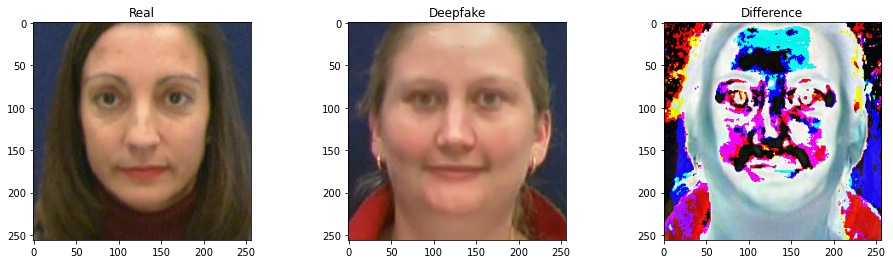

In [48]:
# note that images in OpenCV are in BGR format, 
# and to plot with matplotlib, we convert them to RGB
#real_image = cv2.cvtColor(norm_img_r, cv2.COLOR_BGR2RGB)
#fake_image = cv2.cvtColor(norm_img_f, cv2.COLOR_BGR2RGB)

real_image = norm_img_r
fake_image = norm_img_f

# find the difference between the images
image_diff = None
if real_image.shape == fake_image.shape:
    image_diff = real_image - fake_image

# show the images side by side
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(real_image)
plt.title('Real')
plt.subplot(1, 3, 2)
plt.title('Deepfake')
plt.imshow(fake_image)
if image_diff is not None:
    plt.subplot(1, 3, 3)
    plt.title('Difference')
    plt.imshow(image_diff)
plt.show()


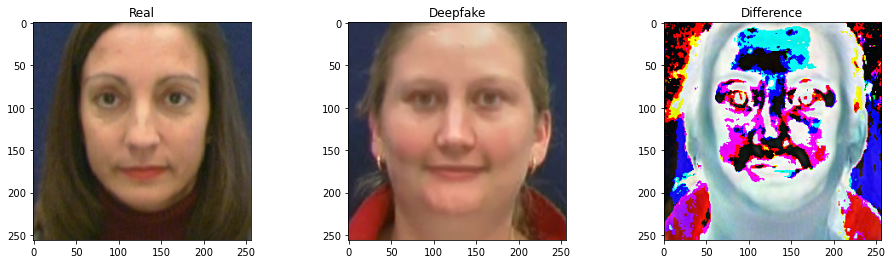

In [49]:
# note that images in OpenCV are in BGR format, 
# and to plot with matplotlib, we convert them to RGB
#real_image = cv2.cvtColor(norm_img_r, cv2.COLOR_BGR2RGB)
#fake_image = cv2.cvtColor(norm_img_f, cv2.COLOR_BGR2RGB)

real_image = compute_blurred_image(real_image)
fake_image = compute_blurred_image(fake_image)

# find the difference between the images
image_diff = None
if real_image.shape == fake_image.shape:
    image_diff = real_image - fake_image

# show the images side by side
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(real_image)
plt.title('Real')
plt.subplot(1, 3, 2)
plt.title('Deepfake')
plt.imshow(fake_image)
if image_diff is not None:
    plt.subplot(1, 3, 3)
    plt.title('Difference')
    plt.imshow(image_diff)
plt.show()


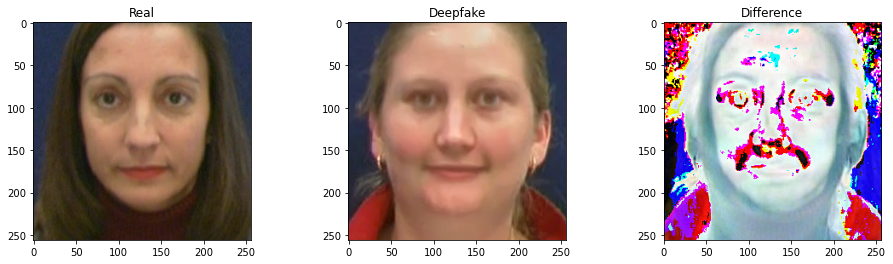

In [50]:
# note that images in OpenCV are in BGR format, 
# and to plot with matplotlib, we convert them to RGB
real_image = cv2.cvtColor(real_faces[0], cv2.COLOR_BGR2RGB)
fake_image = cv2.cvtColor(fake_faces[0], cv2.COLOR_BGR2RGB)

# find the difference between the images
image_diff = None
if real_image.shape == fake_image.shape:
    image_diff = real_image - fake_image

# show the images side by side
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(real_image)
plt.title('Real')
plt.subplot(1, 3, 2)
plt.title('Deepfake')
plt.imshow(fake_image)
if image_diff is not None:
    plt.subplot(1, 3, 3)
    plt.title('Difference')
    plt.imshow(image_diff)
plt.show()


In [51]:
# end